In [67]:
using ALMPC
using OSQP
using LinearAlgebra
using SparseArrays
using Plots
using Test

In [68]:
mass = 1.0    # Mass [kg]
damp = 0.1  # Damping coefficient [N-s/m]

dt = 0.01

Ad = sparse([1.0    0.0     dt                   0.0             ;
0.0    1.0     0.0                 dt               ;
0.0    0.0     1-(damp/mass)*dt     0.0             ;
0.0    0.0     0.0                 1-(damp/mass)*dt])    # State Matrix

Bd = sparse([   0.0 0.0;
                0.0 0.0;
                (1/mass)*dt 0.0;
                0.0 (1/mass)*dt])

Nx, Nu = size(Bd)

umin = [-1, -1]   
umax = [1, 1]

xmin = [-10.0; -10.0; -Inf; -Inf]  
xmax = [10.0; 10.0; Inf; Inf] 

# MPC objective function weights
Q = sparse(1000.0*I(Nx))
R = sparse(.01*I(Nu))
QN = sparse(1000.0*I(Nx))

function pointmass_dynamics(x,u; mass = 1.0, damp = 0.1)
    xdot = zero(x) 
    xdot[1] = x[3]
    xdot[2] = x[4]
    xdot[3] = -(damp/mass)*x[3] + u[1]/mass 
    xdot[4] = -(damp/mass)*x[4] + u[2]/mass 
    return xdot
end

Nmpc = 500

Nd = (Nmpc+1)*(Nx+length(xmin)+length(umin)) - length(umin)

Tfinal = 25           # Final time [s]
Nt = Int(Tfinal/dt)+1    # Number of time steps

x0 = [5.0, 5.0, 0.0, 0.0]
xf = [0.0, 0.0, 0.0, 0.0]
ueq = zeros(2)

# Generate reference trajectory
Xref = ALMPC.linear_trajectory(x0,xf,Nt,dt)     # Reference trajectory for all states
Uref = [copy(ueq) for k = 1:Nt]             # Reference inputs 
tref = range(0,Tfinal, length=Nt)           # Array of timesteps


0.0:0.01:25.0

In [69]:
mpc1 = ALMPC.OSQPController(Nmpc, Q, R, QN, Ad, Bd, length(Xref), Nd)

# Provide the reference trajectory
mpc1.Xref .= Xref
mpc1.Uref .= Uref
mpc1.times .= tref

# Build the sparse QP matrices
ALMPC.buildQP!(mpc1, x0, xmin, xmax, umin, umax, tol=1e-6)

Xmpc1,Umpc1,tmpc1 = ALMPC.simulate(pointmass_dynamics, x0, mpc1, tf=50)

@show Xref[end]
@show Xmpc1[:,end]
@test norm(Xmpc1[end]) < 1e-4  

Constrained!
Controller ran at 118.89032638789209 Hz
Xref[end] = [0.0, 0.0, 0.0, 0.0]
Xmpc1[:, end] = [-5.89322852882436e-14, -5.89322852882436e-14, 5.810536420873678e-14, 5.810536420873678e-14]


Test Passed

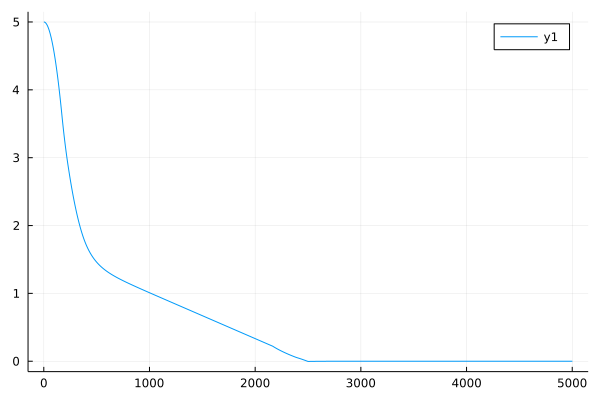

In [70]:
plot(Xmpc1[1,:])

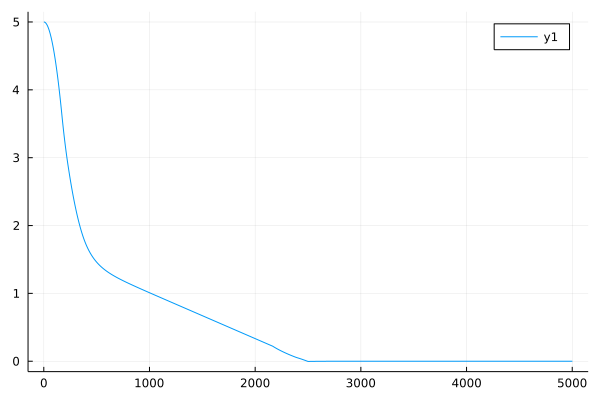

In [71]:
plot(Xmpc1[2,:])

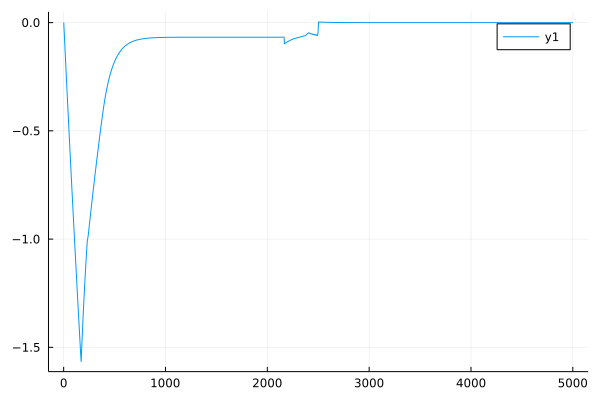

In [72]:
plot(Xmpc1[3,:])

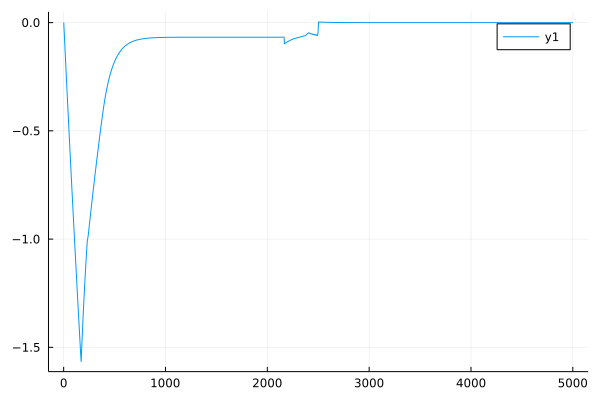

In [73]:
plot(Xmpc1[4,:])

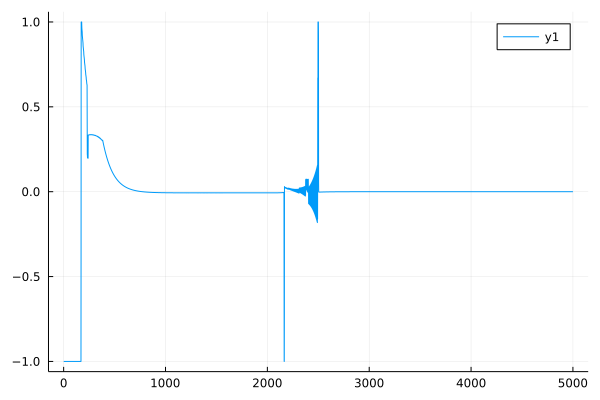

In [74]:
plot(Umpc1[1,:])

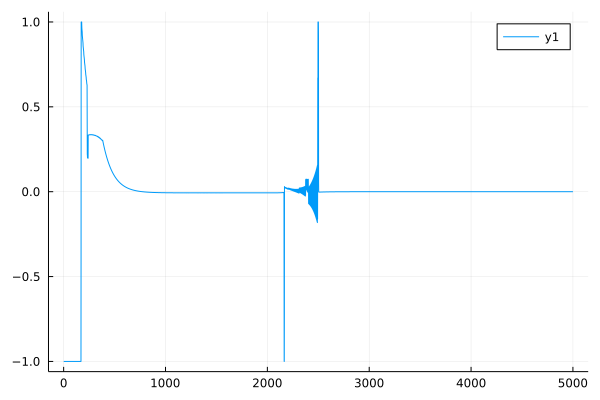

In [75]:
plot(Umpc1[2,:])